# **Final BME Project: 3D Brain Segmentation**

Natalie McKenzie - ncm2165
Eva Melendrez - emm2355

Welcome to our Final Biomedical Engineering Project! In this Kaggle notebook, we will walk you through the process of building a model that segments different parts of the brain in a MRI T1 (3D) scan of a brain. Firstly, let's import our libraries and our raw data! At the end of this cell, we also check to see if a GPU is available to run our code.

In [1]:
#1: import packages
import sys, os
import glob
import math

import numpy as np
import pandas as pd
import skimage.transform as skTrans
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import scipy.interpolate as scInterp
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

cuda = torch.cuda.is_available()
print ("GPU available:", cuda)

# !rm -r test train valid

GPU available: True


In [2]:
#all code for preprocessing of 3d nii files into 2d np arrays
#ran all the code, saved output, added it as input to this project under the dataset "aoe-bme-2d-arrays"
#have commented out this code so I don't accidentally run it all again

# #check number of nii files in each set 
# !ls /kaggle/input/3dbraintissuesegmentation/test/image/*.nii | wc -l
# !ls /kaggle/input/3dbraintissuesegmentation/train/image/*.nii | wc -l
# !ls /kaggle/input/3dbraintissuesegmentation/valid/image/*.nii | wc -l

def clear_files(folder):
    files = glob.glob(os.path.join(folder, "*"))
    for file in files:
        os.remove(f)

root_folder = "/kaggle/input/3dbraintissuesegmentation"
output_folder = "/kaggle/working"

!rm -r test train valid
!mkdir test train valid

def addPadding(array):
    """
    add padding to image so its dimensions are 224x224 since it's divisible by 2^4 (there's four layers with down convolutions)
    """
    diff = [0, 224-array.shape[1], 224-array.shape[2], 224-array.shape[3]]
    padded_array = np.pad(array, ((0, 0), (diff[1]//2, math.ceil(diff[1]/2)), (diff[2]//2, math.ceil(diff[2]/2)), (diff[3]//2, math.ceil(diff[3]/2))))
    return padded_array

def NiftyToNp(root_folder, folder, output_folder):  
    folder_path = os.path.join(root_folder, folder) #path for train folder, for example
    img_folder_path = os.path.join(folder_path, 'image') #path for train image folder, for example
    mask_folder_path = os.path.join(folder_path, 'mask') #path for train mask folder, for example
    output_folder_path = os.path.join(output_folder, folder)
    sbj_list = [i.split("_img.nii")[0] for i in os.listdir(img_folder_path) if i.endswith(".nii")] #use the image folder to get all the subject IDs
    for sbj in sbj_list:
        print (f"currently processing {sbj} in {folder}, {sbj_list.index(sbj)+1} of {len(sbj_list)}          ", end = "\r")
        img = nib.load(os.path.join(img_folder_path, sbj + "_img.nii")).get_fdata() #load data for subject's MRI
        original_img_shape = img.shape
        img = (img-img.min())/(img.max()-img.min()) #scale to [0, 1] -> don't need to do the same for the masks because they're binary as is
        
        #pad and resize image 
        img = addPadding(np.expand_dims(img, axis = 0))
        img = skTrans.resize(img, (1, 112, 112, 112), order = 1, preserve_range = True)
        
        mask_csf = nib.load(os.path.join(mask_folder_path, sbj + "_probmask_csf.nii")).get_fdata()
        mask_gm = nib.load(os.path.join(mask_folder_path, sbj + "_probmask_graymatter.nii")).get_fdata()
        mask_wm = nib.load(os.path.join(mask_folder_path, sbj + "_probmask_whitematter.nii")).get_fdata()
        
        mask = np.zeros(((4,) + original_img_shape)) #combine all the masks into one 4D array 
        mask[1] = mask_csf
        mask[2] = mask_gm
        mask[3] = mask_wm
        
        #pad and resize mask
        mask = addPadding(mask)
        mask[0, np.logical_and.reduce((mask[1] == 0, mask[2] == 0, mask[3] == 0))] = 1.0
        mask = skTrans.resize(mask, (4, 112, 112, 112), order = 1, preserve_range = True)
        
        possible_range = [i for i in range(0, img.shape[1]) if np.sum(mask[0,i,:,:]) != 12544]
        
        #run this whole loop 3x, changing i in img.shape[i] and location of idx in img[idx,:,:] each time
        #create image slices, but only every 7 slices because memory limitations on kaggle
        #112 is divisible by 7 (7x16 = 112), and we can remove the first and last arrays (which contain essentially nothing)
        for idx in range(possible_range[0] + 1, possible_range[-1] + 1, 7):
            
            img_slc = img[:,idx,:,:]
            mask_slc = mask[:,idx,:,:]
            
#             plot_image(mask_slc, img_slc, idx)
            
            #save image and mask slices
            np.save(os.path.join(output_folder_path, f"{sbj}_slc{idx:03}_img.npy"), img_slc)
            np.save(os.path.join(output_folder_path, f"{sbj}_slc{idx:03}_mask.npy"), mask_slc)

def numberOfItemsInFolder(folder):
    listofItems = glob.glob(os.path.join(folder, "*"))
    return (len(listofItems))

#process each folder
folders = ['test', 'train', 'valid']
for curr_folder in folders:
    NiftyToNp(root_folder, curr_folder, output_folder)
    
#check for correct number of items in each folder
for curr_folder in folders:
    print (f"{curr_folder} has {numberOfItemsInFolder(os.path.join(output_folder, curr_folder))} items \n")

rm: cannot remove 'test': No such file or directory
rm: cannot remove 'train': No such file or directory
rm: cannot remove 'valid': No such file or directory
test has 3288 items  sald_031693 in valid, 144 of 144           

train has 9742 items 

valid has 3206 items 



In [3]:
masks = ["background", "csf", "gm", "wm"]

def plot_image(mask_array, image_array, idx, axis, save_root_folder = None):
    plt.figure(figsize = (22,22))
    plt.subplot(1, 5, 1)
    plt.title(f"{idx} image on Axis {axis}")
    plt.imshow(image_array[0], cmap = "gray")
    
    for i in range(len(masks)):
        show_image = mask_array[i]
        plt.subplot(1, 5, i +2)
        plt.title (f"{idx} {masks[i]} on Axis {axis}")
        plt.imshow(show_image, cmap = "gray")
        plt.axis("off")
    plt.tight_layout()
    if save_root_folder:
        plt.savefig(os.path.join(save_root_folder, f"Axis_{axis}_{idx}_Images_And_Masks.png"))
    plt.show()

In [4]:
class BasicDataset(TensorDataset):
    def __init__(self, root_folder, folder, percent_samples = None): #set n_sample lower if you just want to evaluate
        self.folder = os.path.join(root_folder, folder)
        
        self.img_sbj_list = sorted([i.split("_img.npy")[0] for i in os.listdir(self.folder) if i.endswith("img.npy")]) #get all image subject IDs
        self.mask_sbj_list = sorted([i.split("_mask.npy")[0] for i in os.listdir(self.folder) if i.endswith("mask.npy")]) #get all mask subject IDs
        
        #check that there's the right number of mask and image files
        assert self.img_sbj_list == self.mask_sbj_list, f"Mask and Image File Numbers don't match in {folder} folder"
        
        if not percent_samples or percent_samples > len(self.img_sbj_list): #if n_sample isn't set by user
            percent_samples = len(self.img_sbj_list) 
        self.n_samples = int(len(self.img_sbj_list) * percent_samples)
        self.ids = self.img_sbj_list[0: self.n_samples]
        
    def __len__(self):
        return self.n_samples

    #lets you do basicdataset[i]
    def __getitem__(self, i):
        idx = self.ids[i]
        img = np.load(os.path.join(self.folder, idx + "_img.npy")) #expand img dims so it's a 3d array, like the masks
        mask = np.load(os.path.join(self.folder, idx + "_mask.npy"))
        
        #lets you do basicdataset[i]['image']
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor),
            'img_id': i,
            'sbj_id':self.img_sbj_list[i]
        }

In [10]:
#um come back to this later because you maybe wanted to do a resnet    
class Res_Conv_Block_3d(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(ch_in, ch_out, kernel_size = 3),
            nn.GroupNorm(8, ch_out), 
            nn.ReLU(inplace = True),
            nn.Conv3d(ch_out, ch_out, kernel_size = 3),
            nn.GroupNorm(8, ch_out),
            nn.ReLU(inplace = True)
        )
        self.Conv_1x1 = nn.Conv3d(ch_in, ch_out, kernel_size = 1) #Q: what?
    def forward(self, x):
        return self.Conv_1x1(x) + self.conv(x)
    
#use group normalization instead of batch normalization because small batch sizes
#https://arxiv.org/pdf/1803.08494.pdf
#could also do layer normalization or instance normalization, but both have "limited success in visual recognition"

In [5]:
#3: U-Net-like architecture
class DoubleConv(nn.Module):
    """(2d convolution, batch norm, relu) x 2"""
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size = 3, padding = "same"), #kernel size of three seems to be standard
            nn.BatchNorm2d(ch_out), #Q: how do you determine what the group size should be
            nn.ReLU(inplace = True),
            nn.Conv2d(ch_out, ch_out, kernel_size = 3, padding = "same"),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace = True)
        )
    def forward(self, x):
        return self.double_conv(x)

class DownConv(nn.Module):
    """maxpool, DoubleConv"""
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.down_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(ch_in, ch_out)
        )
    def forward(self, x):
        return self.down_conv(x)

class UpConv(nn.Module):
    """upsample, 1x1 conv, concatenate with earlier layer, DoubleConv"""
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = True),
            nn.Conv2d(ch_in, ch_out, kernel_size = 1)
        )
        self.conv = DoubleConv(ch_out * 2, ch_out)
    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim = 1) # concatenate along channel axis, also this makes there be double the number of channels there should be
        x = self.conv(x) #which is why the self.conv needs to have ch_in = ch_out * 2
        return x
    
class OutConv(nn.Module):
    """1x1 conv, softmax (last operation)"""
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv_final = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size = 1),
            nn.Softmax(dim = 1) #asdlfiawhf;k made the opposite mistake as last time and had this as logsoftmax for way too long
        )
    def forward(self, x):
        return self.conv_final(x)
   

In [6]:
#UNet Architecture
#currently literally just the u-net
class ThisCNN(nn.Module):
    def __init__(self, name, n_channels, n_classes):
        super().__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inputL = DoubleConv(n_channels, 32)   # Reduced from 64 to 32
        self.down1 = DownConv(32, 64)              # Reduced from 64, 128 to 32, 64
        self.down2 = DownConv(64, 128)             # Reduced from 128, 256 to 64, 128
        self.down3 = DownConv(128, 256)            # Reduced from 256, 512 to 128, 256
        self.down4 = DownConv(256, 512)            # Reduced from 512, 1024 to 256, 512
        self.up1 = UpConv(512, 256)                # Reduced from 1024, 512 to 512, 256
        self.up2 = UpConv(256, 128)                # Reduced from 512, 256 to 256, 128
        self.up3 = UpConv(128, 64)                 # Reduced from 256, 128 to 128, 64
        self.up4 = UpConv(64, 32)                  # Reduced from 128, 64 to 64, 32
        self.outputL = OutConv(32, n_classes)      # Reduced from 64 to 32

        
    def forward(self, x):
        x = self.inputL(x)
        
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        
        #wow look at that u-net concatenating
        u1 = self.up1(d4, d3)
        u2 = self.up2(u1, d2)
        u3 = self.up3(u2, d1)
        u4 = self.up4(u3, x)
        
        x = self.outputL(u4)
        
        return x

In [7]:
def loss_function(criterion, images, model_output, gt_masks, mode):
    """
    calculate loss for the three tissue type channels only over the brain area
    compute loss for background channel over the whole area
    """
    
    if mode == "val":
        torch.manual_seed(1102)
        np.random.seed(1102)
        
    #remove extra dimension
    images_squeezed = torch.squeeze(images, dim = 1)
    
    #turn this into binary brain map (values are 1 where brain, 0 where background)
    brain_map = (images_squeezed > 0).float()
    
    #stack the brain maps so their shape is batch_size x 4 x 112 x 112 (like model's output)
    #computing loss for background channel over the whole area, so that will just be filled with ones 
    ones = torch.ones((brain_map.shape)).cuda()
    stacked_brain_map = torch.stack(([ones, brain_map, brain_map, brain_map]), dim = 1)
    
    #only consider the values inside the brain (zero out others using 0s in bg of stacked brain map)
    isolated_images = torch.mul(stacked_brain_map, model_output)
    
    #see how the probabilities at each (prediction vs ground truth) compare using whatever criterion you prefer
    #computes avg loss over all the brain voxels
    loss = criterion(isolated_images, gt_masks) #make sure reduction = "sum" so you can do average over entire brain area
    num_brain_voxels = stacked_brain_map.sum()
    loss = loss / num_brain_voxels
    
    #return the isolated_images and the stacked_brain_map too because they're helpful for other functions
    return loss, isolated_images, stacked_brain_map
    
def pearson_coeff(isolated_image, target, stacked_brain_map):
    """
    calculate pearson correlation coefficient over the brain area
    """
    #flatten so you can do pearson correlation calculation
    gt_flattened = torch.flatten(target)
    iso_flattened = torch.flatten(isolated_image)
    mask_flattened = torch.flatten(stacked_brain_map)
    
    #only keep the values where there is brain (like not just zero them out, but discard them)
    gt_flattened = gt_flattened[mask_flattened.nonzero(as_tuple = True)]
    iso_flattened = iso_flattened[mask_flattened.nonzero(as_tuple = True)]
    
    #remove from cupa and turn into numpy array
    iso_flattened = iso_flattened.cpu().detach().numpy()
    gt_flattened = gt_flattened.cpu().detach().numpy()
    
    #calculate and return pearson correlation coefficient
    pearson = np.corrcoef(iso_flattened, gt_flattened)[0][1]
    return pearson

In [8]:
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    #create folder to model in (if not already existing)
    if not os.path.isdir(f'{net.name}'):
        os.mkdir(f'{net.name}')
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = []
    train_pearson = []
    
    valid_loss = []
    valid_pearson = []
    
    #TRAINING
    for epoch in range(epochs):
        net.train()
        
        train_batch_loss = []
        train_batch_pearson = []
        
        for i, batch in enumerate(train_dataloader):
            
            #load image and gt mask for the batch and mount to cupa 
            imgs = batch['image'].cuda()
            masks = batch['mask'].cuda()

            #load model prediction w/ current weights
            pred = net(imgs)

            #compute batch loss and append to overall training loss
            loss, isolated_images, stacked_brain_map = loss_function(criterion, imgs, pred, masks, 'train')
            batch_loss = loss.item() #this just turns it into a number instead (i think it was a tensor)
            train_batch_loss.append(batch_loss)

            #compute batch's pearson coeff and append to overall
            batch_pearson = pearson_coeff(isolated_images, masks, stacked_brain_map)
            train_batch_pearson.append(batch_pearson)

            optimizer.zero_grad() #reset gradient values
            loss.backward() #compute backwards loss
            optimizer.step() #update weights
            
            #update progress (bc the end = '\r' rewrites over the last!)
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, Pearson Coefficient: {batch_pearson}', end='\r')
        
        #calculate averages and append to overall
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_pearson = np.array(train_batch_pearson).mean()

        train_loss.append(average_training_loss)
        train_pearson.append(average_training_pearson)
        
        #VALIDATION
        net.eval()
        valid_batch_loss = list()
        valid_batch_pearson = list()
        
        #don't calculate gradient since you're not trying to train here, just evaluate
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                #load image and mask for batch, mount to cupa
                imgs = batch['image'].cuda()
                masks = batch['mask'].cuda()

                #load model prediction w/ current weights
                pred = net(imgs)

                # compute batch loss and append to overall validation loss
                loss, isolated_images, stacked_brain_map = loss_function(criterion, imgs, pred, masks, 'val')
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                #compute batch's pearson coeff and append to overall validation loss
                batch_pearson = pearson_coeff(isolated_images, masks, stacked_brain_map)
                valid_batch_pearson.append(batch_pearson)

                #update progress (bc the end = '\r' rewrites over the last!)
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, Pearson Coefficient: {batch_pearson}', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_pearson = np.array(valid_batch_pearson).mean()
        valid_loss.append(average_validation_loss)
        valid_pearson.append(average_validation_pearson)
        
        #print final evaluation of epoch 
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training Pearson score: {average_training_pearson}, Validation Loss: {average_validation_loss}, Validation Pearson Coefficient: {average_validation_pearson}')

        #save model 
        #note: since there's only 50 epochs you can change to {:02}
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_pearson, valid_loss, valid_pearson

In [9]:
def dice_coeff_CM(isolated_image, target, stacked_brain_map):
    """
    calculate dice coefficient to evaluate model in testing stage and also return confusion matrix
    literally just convenient to do them together since they need the same inputs and you only need either for the testing stage
    not going to include bacground in calcations because there is so much background, it'll make the dice score higher than it should be
    """
    
    #create dictionary for each channel
    #ie. gt1 would csf, 2 gm, 3 wm
    masks_list = ["gt1", "gt2", "gt3", "iso1", "iso2", "iso3"]
    masks_dict = {i :{} for i in masks_list}
    
    #create maps with values of 0, 1, 2, 3, depending on which tissue type is the most likely to exist there (max value)
    #reminder: 0 is background here

    full_map_model = torch.argmax(isolated_image, 1) 
    full_map_gt = torch.argmax(target, 1)
    #shape of these is batch_size x 122 x 122
    
#     #don't consider background channel in dice score calculations / confusion matrix
#     full_map_model = full_map_model[:,[1, 2, 3],:, :]
#     full_map_gt = full_map_gt[:,[1, 2, 3], :, :]
    
    #binary_brain is a batch_size x 122x122 array that is 0 where background, 1 where brain
    #brain_flattened is 1d version of that
    binary_brain = stacked_brain_map[:,1,:,:]
    brain_flattened = torch.flatten(binary_brain)
     
    #okay quick pause for confusion matrix calculations
    
    #flatten because that's needed for CM calculations
    CM_full_map_model = torch.flatten(full_map_model)
    CM_full_map_gt = torch.flatten(full_map_gt)
    
    #detach from cupa and turn into numpy arrays for CM calculation
    CM_full_map_model = CM_full_map_model.cpu().detach().numpy()
    CM_full_map_gt = CM_full_map_gt.cpu().detach().numpy()
    CM = confusion_matrix(CM_full_map_gt, CM_full_map_model)
    
    #okay back to dice_scores
    dice_scores = []
    
    #calculate one dice score for each tissue type
    for i in range (1, 4):
        #key is a tensor where 0 if not correct tissue type (background or other tissue), 1 if correct tissue type
        masks_dict["gt" + str(i)] = (full_map_gt == i).float()
        masks_dict["iso" + str(i)] = (full_map_model == i).float()
            
        #make flattened numpy arrays that only contain within-brain mask values (background values taken out)
        masks_dict["gt" + str(i)] = torch.flatten(masks_dict["gt" + str(i)])
        masks_dict["gt" + str(i)] = masks_dict["gt" + str(i)][brain_flattened.nonzero(as_tuple = True)]
        masks_dict["gt" + str(i)] = masks_dict["gt" + str(i)].cpu().detach().numpy()
        
        masks_dict["iso" + str(i)] = torch.flatten(masks_dict["iso" + str(i)])
        masks_dict["iso" + str(i)] = masks_dict["iso" + str(i)][brain_flattened.nonzero(as_tuple = True)]
        masks_dict["iso" + str(i)] = masks_dict["iso" + str(i)].cpu().detach().numpy()
    
        #okay wait actually none of the mask_dict stuff is really necessary since you're not accessing the dictionaries later...
        #like you're literally taking these values and assigning them new names...
        #note: come back and delete all the dictionary stuff... literally just give them the below names from the beginning
        model_output = masks_dict["iso" + str(i)]
        gt = masks_dict["gt" + str(i)]
        eps = 0.00001 #so there's no dividing by zero
        
        #calculate dice scores and append to overall dice scores list
        dice = (np.sum(model_output[gt == 1]) * 2.0 + eps) / (np.sum(model_output) + np.sum(gt) + eps)
        dice_scores.append(dice)
    
    #calculate and return avg dice scores and confusion matrix info
    avg_dice = sum(dice_scores)/len(dice_scores)
    return avg_dice, CM

#TESTING
def test_net(net, test_dataloader, loss_function):
#     #COME BACK HERE, BOOKMARK
#     #make folder to save model predictions in but also are we saving those
#     if not os.path.isdir('/kaggle/working/pred_mask'):
#         os.mkdir('/kaggle/working/pred_mask')
        
    net.eval()
    
    n_test = len(test_dataloader)
    test_batch_loss = []
    test_batch_pearson = []
    test_batch_dice = []
    test_batch_CM = []
    all_imgs = []
    all_labels = list()
    all_preds = list()
    
    #no need to update gradient
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):

            #load image and mask for batch, mount to cupa
            imgs = batch['image'].cuda()
            masks = batch['mask'].cuda()
            
            #load model prediction w/ "best" weights
            pred = net(imgs)
            
            #compute batch loss and append to overall validation loss
            loss, isolated_images, stacked_brain_map = loss_function(criterion, imgs, pred, masks, 'test')
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)
            
            #compute batch's pearson coeff and append to overall validation loss            
            batch_pearson = pearson_coeff(isolated_images, masks, stacked_brain_map)
            test_batch_pearson.append(batch_pearson)
            
            #compute batch's dice score and confusion matrix and append to overall lists
            batch_dice, batch_CM = dice_coeff_CM(isolated_images, masks, stacked_brain_map)
            test_batch_dice.append(batch_dice)
            test_batch_CM.append(batch_CM)
            
            pred = pred.cpu().detach().numpy()
            imgs = imgs.cpu().detach().numpy()
            labels = batch['sbj_id']
            all_labels+=labels
            all_preds.append(pred)
            all_imgs.append(imgs)
            

            #update progress
            print(f'Test Batch {i+1}/{n_test} - Loss: {batch_loss}, Pearson Corr: {batch_pearson}, DICE score: {batch_dice}', end='\r')
        
        #find averages of all metrics and return them
        test_loss = np.array(test_batch_loss).mean()
        test_dice = np.array(test_batch_dice).mean()
        test_pearson = np.array(test_batch_pearson).mean()
        test_CM = np.array(test_batch_CM).mean(axis = 0)
        
    return all_imgs, all_labels, all_preds, test_loss, test_dice, test_pearson, test_CM

In [10]:
def CM(test_CM, save_root_folder, label):
    """
    given CM values, return a nice little visualization of them :), but with the background values removed because there's too many 
    """
    
    #turn into panda dataframe so you can add labels!
    df_cm = pd.DataFrame(test_CM, index = ["Background", "CSF", "GM", "WM"],
                     columns = ["Background", "CSF", "GM", "WM"])
    
    #remove the background >:(
    df_cm.pop("Background")
    df_cm = df_cm.drop("Background", axis = "index")
    
    #plot 
    plt.figure(figsize = (12,10))
    plt.title('Confusion Matrix')
    sns.heatmap(df_cm, annot = True, annot_kws = {"size": 15})
    plt.ylabel('True labels')
    plt.xlabel('predicted labels')
    
    #save plot
    plt.savefig(os.path.join(save_root_folder, f"{label}_Confusion_Matrix.png"))
    plt.show()

def learning_curve(best_epoch, train_loss, valid_loss, train_pearson, valid_pearson, save_root_folder):
    """
    return visualization of how the metrics improved during each epoch (learning curve)
    """
    fig, (ax1, ax2) = plt.subplots(figsize = (15, 8), ncols = 2)
    fig.suptitle("Learning Curve", fontsize = 18)
        
    #plot losses on first graph
    ax1.set_ylabel("Loss", fontsize = 15)
    ax1.set_xlabel("Epoch", fontsize = 15)
    ax1.set_xticks(np.arange(EPOCHS, step = 10) + 1)
    ax1.plot(np.arange(EPOCHS) + 1, train_loss, '-o', label = "Training")
    ax1.plot(np.arange(EPOCHS) + 1, valid_loss, '-o', label = "Validation")
    ax1.axvline(best_epoch, color = 'm', lw = 4, alpha = 0.5, label = "Best Epoch") #highlight the best epoch
    
    #plot pearson coefficients on second graph    
    ax2.set_ylabel("Pearson Coeff", fontsize = 15)
    ax2.set_xlabel("Epoch", fontsize = 15)
    ax2.set_xticks(np.arange(EPOCHS, step = 10) + 1)
    ax2.plot(np.arange(EPOCHS) + 1, train_pearson, '-o', label = "Training")
    ax2.plot(np.arange(EPOCHS) + 1, valid_pearson, '-o', label = "Validation ")
    ax2.axvline(best_epoch, color = 'm', lw = 4, alpha = 0.5, label = "Best Epoch") #highlight the best epoch

    
    plt.legend()
    plt.tight_layout()
    
    #save plot
    plt.savefig(os.path.join(save_root_folder, "Learning_Curve.png"))
    plt.show()

Batches in Train DataLoader: 58
Batches in Validation DataLoader: 19
Batches in Test DataLoader: 20
EPOCH 1/50 - Training Loss: 0.25952826029267806, Training Pearson score: 0.3171784771875647, Validation Loss: 0.25428415050632075, Validation Pearson Coefficient: 0.4223967711618387
EPOCH 2/50 - Training Loss: 0.21174960377915153, Training Pearson score: 0.5958622845169729, Validation Loss: 0.1926675525150801, Validation Pearson Coefficient: 0.6861257897549441
EPOCH 3/50 - Training Loss: 0.17752036375218425, Training Pearson score: 0.7326579970740557, Validation Loss: 0.1619090586900711, Validation Pearson Coefficient: 0.7838487752045666
EPOCH 4/50 - Training Loss: 0.14925880576002187, Training Pearson score: 0.8100288831951483, Validation Loss: 0.13624934224705948, Validation Pearson Coefficient: 0.8410621142403082
EPOCH 5/50 - Training Loss: 0.1256595280920637, Training Pearson score: 0.85752794093827, Validation Loss: 0.11492179334163666, Validation Pearson Coefficient: 0.877157681211

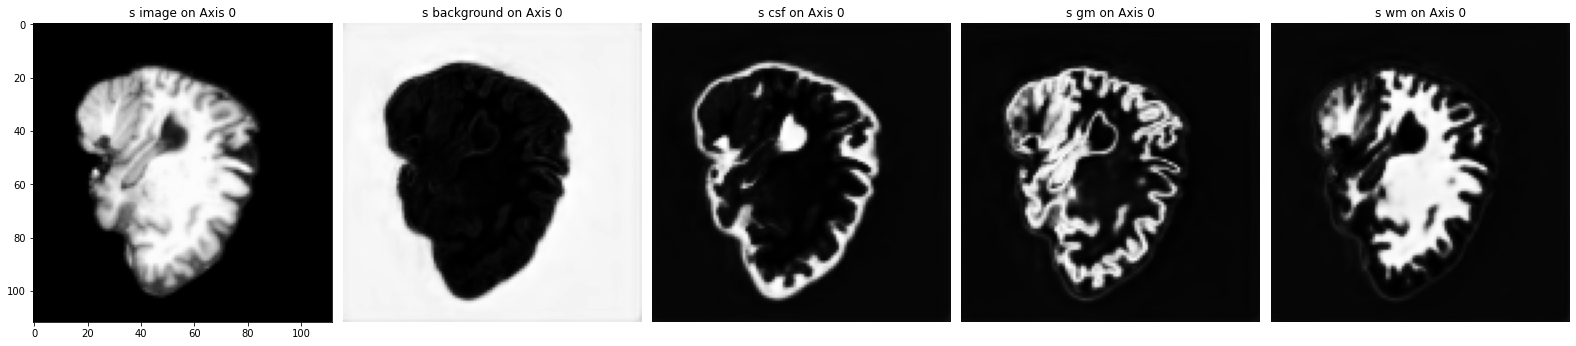

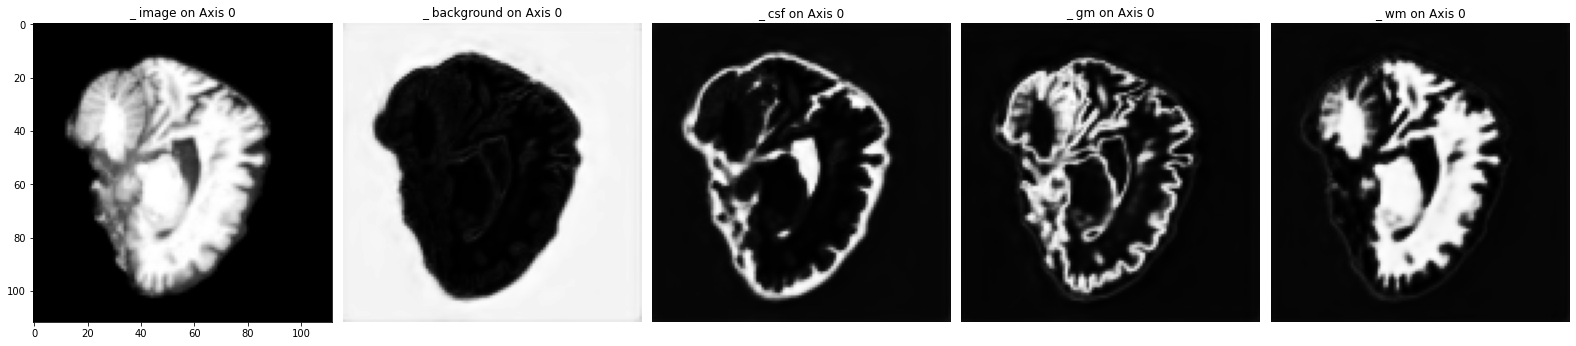

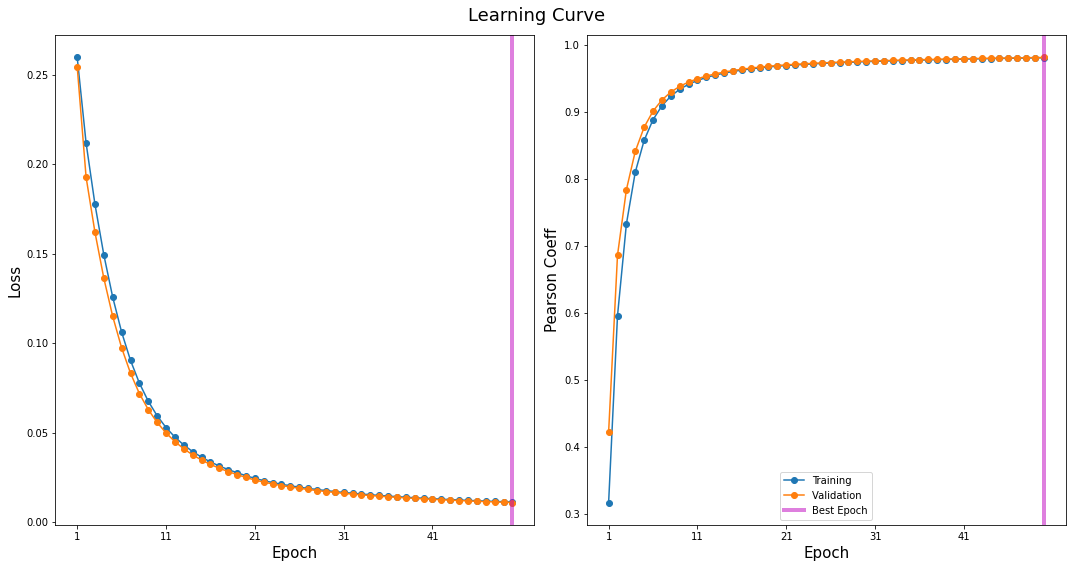

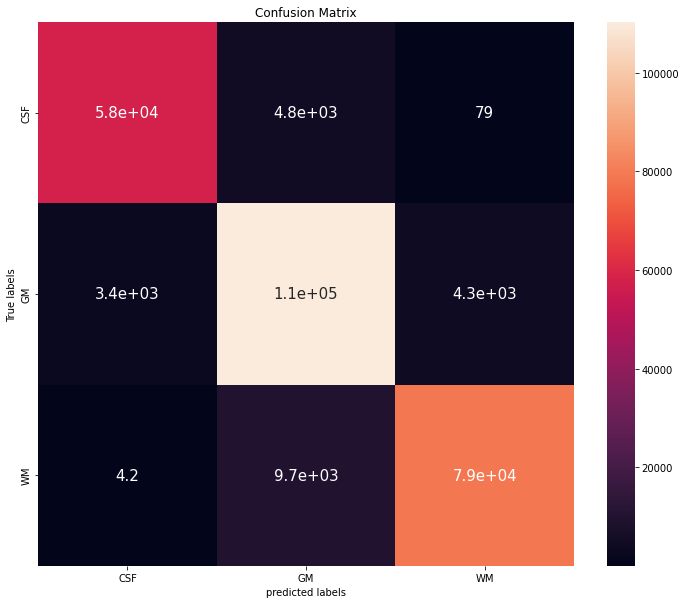

Batches in Train DataLoader: 72
Batches in Validation DataLoader: 24
Batches in Test DataLoader: 25
EPOCH 1/50 - Training Loss: 0.2844788630803426, Training Pearson score: 0.33097138627458567, Validation Loss: 0.25324123663206893, Validation Pearson Coefficient: 0.525154439578711
EPOCH 2/50 - Training Loss: 0.2211637312753333, Training Pearson score: 0.6251813300874254, Validation Loss: 0.1948943759004275, Validation Pearson Coefficient: 0.7290062718606456
EPOCH 3/50 - Training Loss: 0.17407009998957315, Training Pearson score: 0.7730671929550764, Validation Loss: 0.1525131594389677, Validation Pearson Coefficient: 0.8294736473751523
EPOCH 4/50 - Training Loss: 0.13716069370922115, Training Pearson score: 0.8469059086213861, Validation Loss: 0.12093087999771039, Validation Pearson Coefficient: 0.8760456840889698
EPOCH 5/50 - Training Loss: 0.10954431185705794, Training Pearson score: 0.8855782044594344, Validation Loss: 0.0975186787545681, Validation Pearson Coefficient: 0.903328708996

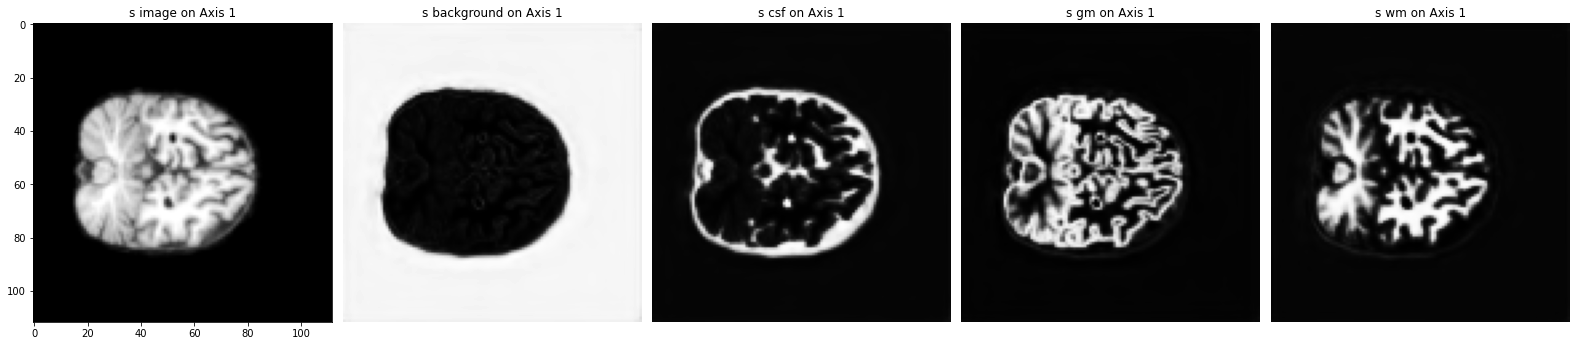

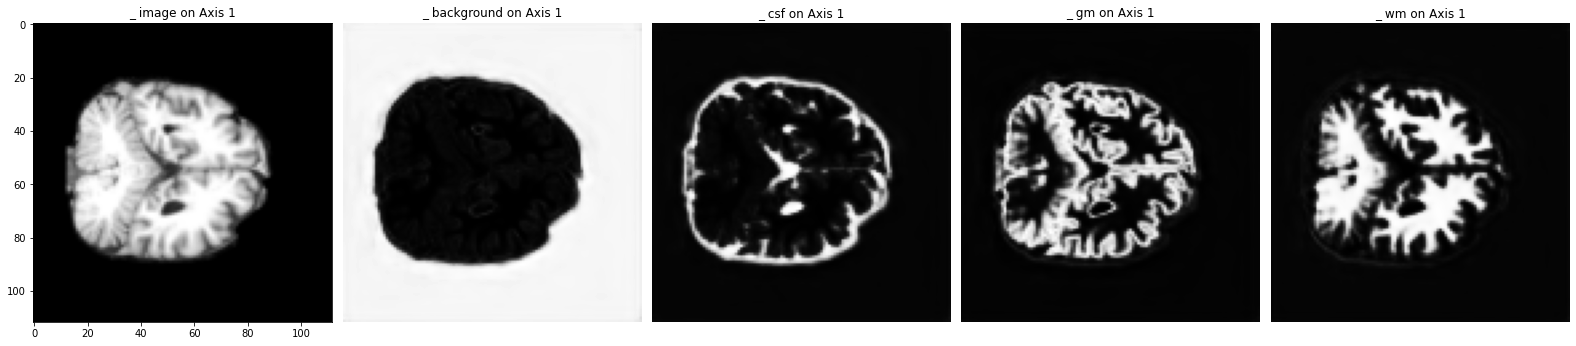

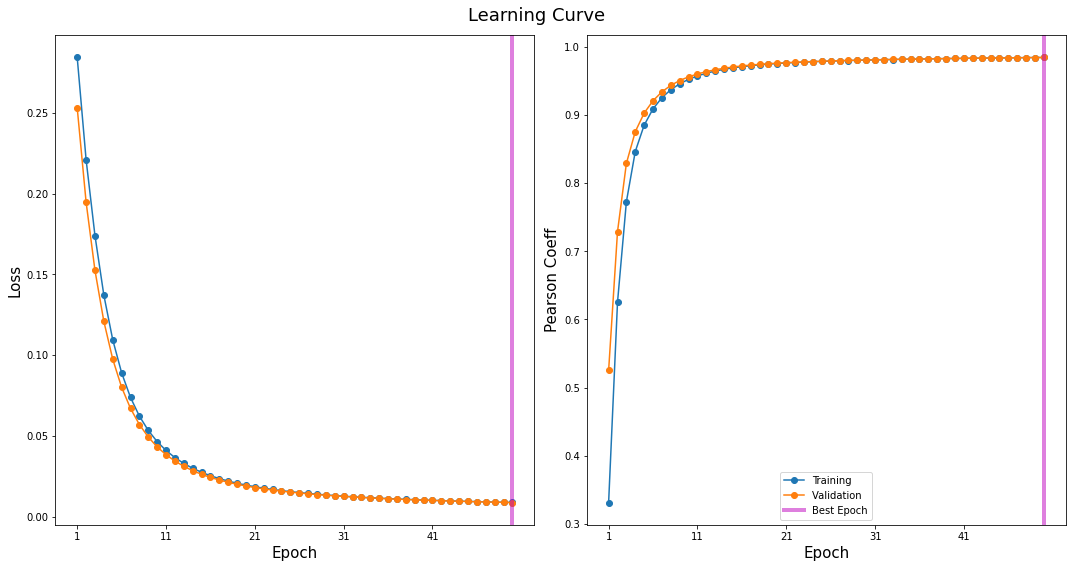

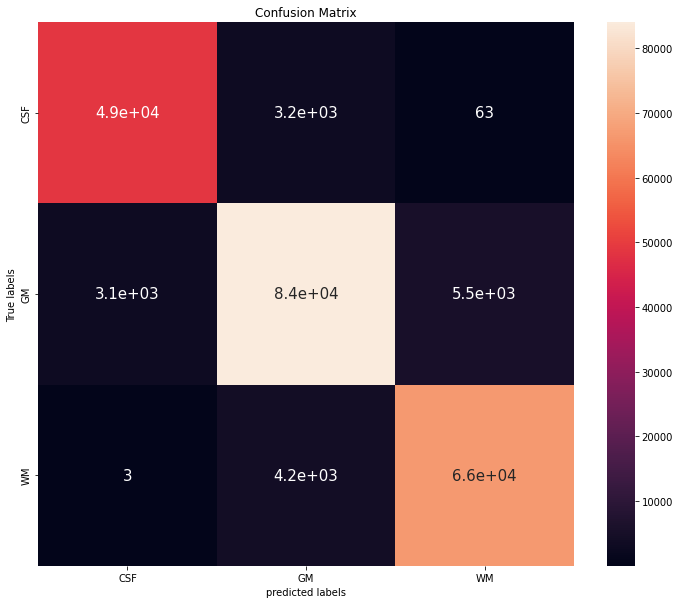

Batches in Train DataLoader: 62
Batches in Validation DataLoader: 21
Batches in Test DataLoader: 21
EPOCH 1/50 - Training Loss: 0.26776693496973286, Training Pearson score: 0.3222219699227834, Validation Loss: 0.2603531437260764, Validation Pearson Coefficient: 0.4337616075347227
EPOCH 2/50 - Training Loss: 0.21675117818578596, Training Pearson score: 0.6022306243444445, Validation Loss: 0.19595587537402198, Validation Pearson Coefficient: 0.7016503141475463
EPOCH 3/50 - Training Loss: 0.1799501442620831, Training Pearson score: 0.7403009863719738, Validation Loss: 0.1624417645590646, Validation Pearson Coefficient: 0.8005778638521406
EPOCH 4/50 - Training Loss: 0.14934192669968452, Training Pearson score: 0.8188486505292958, Validation Loss: 0.13488833606243134, Validation Pearson Coefficient: 0.8560992396865492
EPOCH 5/50 - Training Loss: 0.12418544484722999, Training Pearson score: 0.8658696174590867, Validation Loss: 0.11246933326834724, Validation Pearson Coefficient: 0.8898142937

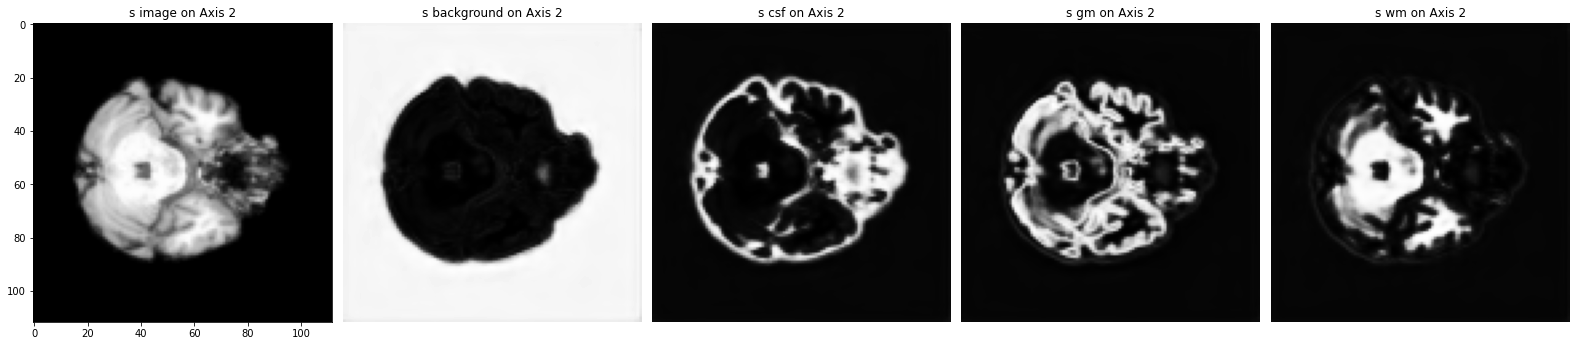

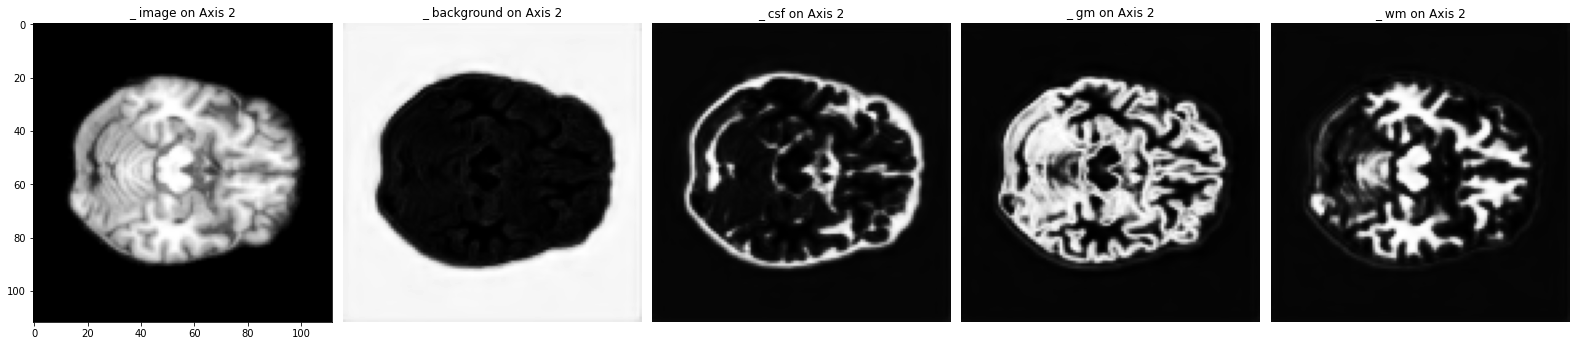

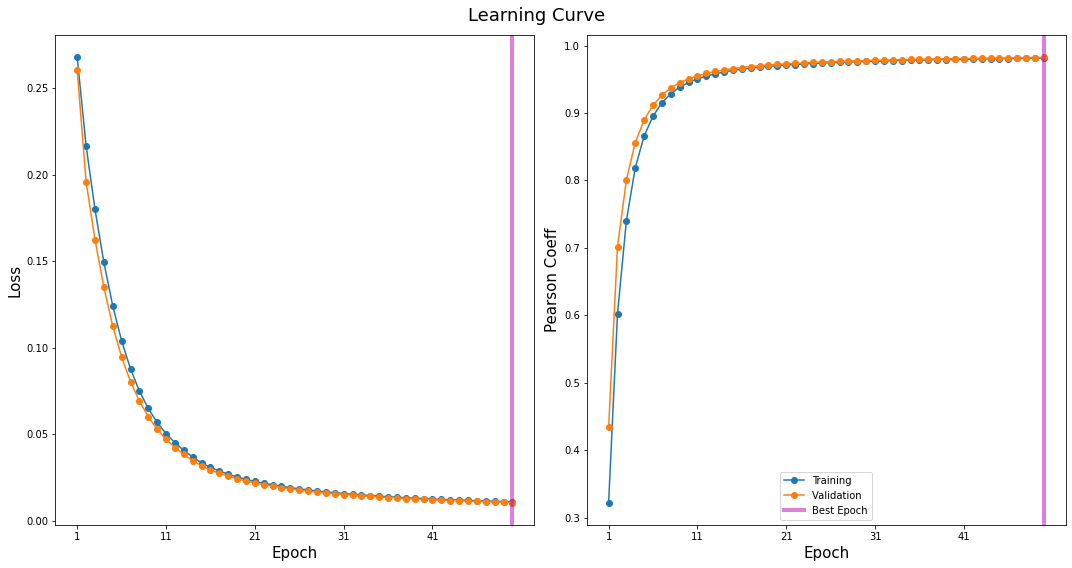

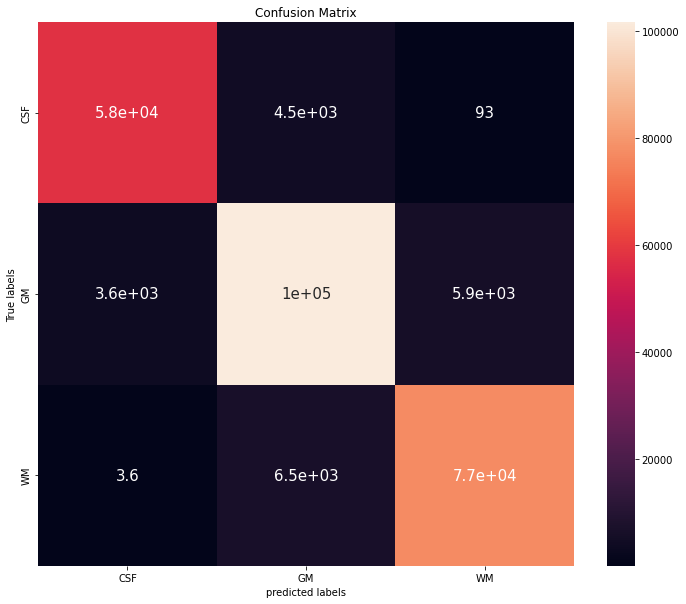

In [11]:
#make directory to save figures in 
if not os.path.isdir("figures"):
    os.mkdir("figures")
save_root_folder = "/kaggle/working/figures"
final_predictions = list()
final_labels = list()
final_images = list()

for axis in range(3):
    torch.manual_seed(1102)
    np.random.seed(1102) #Q: should i reset the seeds each time?
    root_folder = f"/kaggle/input/axis-{axis}-slices"

    #2: datasets and dataloaders
    percent = 1
    train_dataset = BasicDataset(root_folder, 'train', percent)
    valid_dataset = BasicDataset(root_folder, 'valid', percent)
    test_dataset = BasicDataset(root_folder, 'test', percent)

    batch_size = 85
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    valid_loader = DataLoader(valid_dataset, batch_size = batch_size)
    test_loader = DataLoader(test_dataset, batch_size = batch_size)
    
    print (f"Batches in Train DataLoader: {len(train_loader)}")
    print (f"Batches in Validation DataLoader: {len(valid_loader)}")
    print (f"Batches in Test DataLoader: {len(test_loader)}")

    #display the first five image slices
#     for slc in range (5):
#         plot_image(train_dataset[slc]['mask'], train_dataset[slc]['image'], train_dataset[slc]['sbj_id'], axis, save_root_folder)
    
    #create instance of u-net architecture
    model = ThisCNN(f"Model_Axis_{axis}", 1, 4)
    model = model.cuda()
    
        
    #4: define loss function and optimization method
    #define optimizer 
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
    

    #define loss function
    criterion = nn.MSELoss(reduction = "sum")
    
    
    #5: train the model for at least 50 epochs 
    #6: validate and save the model at the end of each epoch
    EPOCHS = 50
    train_loss, train_pearson, valid_loss, valid_pearson = train_net(model, EPOCHS, train_loader, valid_loader, optimizer, loss_function)

    
    #7: choose the best epoch and load the weights at that specific epoch
    best_epoch = np.argmax(valid_pearson) + 1 #just add one bc epochs start at 1
    print (f"Best Epoch: {best_epoch}")

    #load weights to model
    state_dict = torch.load(f'./Model_Axis_{axis}/epoch_{best_epoch:03}.pth')
    torch.save(state_dict, f"/kaggle/working/Axis_{axis}_model_best_epoch.pth")
    !rm -r './Model_Axis_{axis}'
    model.load_state_dict(state_dict)
    model.cuda()
    

    #8: test the model on the test data
    test_imgs, test_labels, test_predictions, test_loss, test_dice, test_pearson, test_CM = test_net(model, test_loader, loss_function)
    final_predictions.append(test_predictions)
    final_labels.append(test_labels)
    final_images.append(test_imgs)
    print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Pearson Correlation: {test_pearson}')
    
    for slc in range (3, 5):
        plot_image(test_predictions[0][slc], test_imgs[0][slc], test_labels[0][slc], axis)

    
    #9: generate and save all the figures you might need for the presentation (dataset distribution, learning curve, confusion matrix, etc.)
    learning_curve(best_epoch, train_loss, valid_loss, train_pearson, valid_pearson, save_root_folder)
    CM(test_CM, save_root_folder, f"Axis {axis}")
                    
    model = model.cpu() #remove old model from gpu

In [1]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

y_pred = model.predict(X_val)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, color='blue', lw=2)
plt.title('Precision-Recall Curve', fontsize=15)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a random point to show the specific model's performance
plt.scatter(recall, precision, color='red', s=100, 
            label=f'Model Performance\nPrecision: {precision:.2f}\nRecall: {recall:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

In [12]:
def processNifti(filename):
    """
    turn .nii files into numpy arrays 
    pads them up to 256x256x256 for the sake of symmetry
    rescales them down to 128x128x128 bc not enough memory
    final shape is 1x128x128x128 (extra axis for channels)
    """
    # reference: https://ianmcatee.com/converting-a-nifti-file-to-an-image-sequence-using-python/
    img = nib.load(filename)
    img = np.array(img.dataobj)
    img = np.array(img) / img.max()
    shape = img.shape
    diff = [224-img.shape[0], 224-img.shape[1], 224-img.shape[2]]
    img = np.pad(img, ((diff[0]//2, math.ceil(diff[0]/2)), (diff[1]//2, math.ceil(diff[1]/2)), (diff[2]//2, math.ceil(diff[2]/2))))
    img = skTrans.resize(img, (112, 112, 112), order = 1, preserve_range = True)
    img = np.expand_dims(img, axis = 0)
    return img

class LoadOriginals():
    def __init__(self, orig_test_folder, percent_samples = None):
        self.imgs_dir = os.path.join(orig_test_folder, "image/")
        self.masks_dir = os.path.join(orig_test_folder, "mask/")
        
        #create a list of all the files of each specific tissue type, and sort them
        self.imgs_file = sorted(glob.glob(os.path.join(self.imgs_dir, '*.nii')))
        self.csf_masks_file = sorted(glob.glob(os.path.join(self.masks_dir, '*probmask_csf.nii')))
        self.gm_masks_file = sorted(glob.glob(os.path.join(self.masks_dir, '*probmask_graymatter.nii')))
        self.wm_masks_file = sorted(glob.glob(os.path.join(self.masks_dir, '*probmask_whitematter.nii')))
        
        #check that there's the right number of each tissue type
        assert 3 * len(self.imgs_file) == (len(self.csf_masks_file) + len(self.gm_masks_file) + len(self.wm_masks_file)), f"Mask and Image Numbers don't match in {folder} folder"
        assert len(self.csf_masks_file) == len (self.gm_masks_file), f"CSF and Gray Matter Mask Image Numbers don't match in {folder} folder"
        assert len(self.csf_masks_file) == len (self.wm_masks_file), f"CSF and White Matter Mask Image Numbers don't match in {folder} folder"
        
        self.sbj_list = sorted([i.split("_img.nii")[0] for i in os.listdir(self.imgs_dir) if i.endswith("img.nii")]) #get all image subject IDs
        
        if not percent_samples or percent_samples > len(self.sbj_list): #if n_sample isn't set by user
            percent_samples = len(self.sbj_list) 
        self.n_samples = int(len(self.sbj_list) * percent_samples)
        self.ids = self.sbj_list[0: self.n_samples]
        
    def __len__(self):
        return self.n_samples

    #lets you do loadOriginals[sbj_id]
    def __getitem__(self, sbj_id):    
        #turn .nii files into numpy arrays
        img = processNifti(os.path.join(self.imgs_dir, sbj_id + "_img.nii"))
        
        masks = np.zeros((4, 112, 112, 112))
        masks[1] = processNifti(os.path.join(self.masks_dir, sbj_id + "_probmask_csf.nii"))
        masks[2] = processNifti(os.path.join(self.masks_dir, sbj_id + "_probmask_graymatter.nii"))
        masks[3] = processNifti(os.path.join(self.masks_dir, sbj_id + "_probmask_whitematter.nii"))
        masks[0, np.logical_and.reduce((masks[1] == 0, masks[2] == 0, masks[3] == 0))] = 1.0
        
        tensor_img = np.expand_dims(img, axis = 0)
        tensor_masks = np.expand_dims(masks, axis = 0)
        
        #lets you do loadOriginals[sbj_id]['img']
        return {
            'np_img': img,
            'np_masks': masks,
            'tensor_img': torch.from_numpy(tensor_img).type(torch.FloatTensor),
            'tensor_masks': torch.from_numpy(tensor_masks).type(torch.FloatTensor)
        }

In [ ]:
#note: final_predictions/final_images shape:
#first[] is axis, second[] is batch_number, third[] is 
#note: final_predictions shape is:
#first[] is axis
#second is batch_num
#third is batch_size
#then channel, 122x122


sbj_to_all_slices = dict()
sbj_to_all_preds = dict()

for axis in range(3): #this is for the slices of images -> ie. saggital, coronal, transversal.
    flat_final_preds = final_predictions[axis][0]
    for batch in range(len(final_predictions[axis])-1):
        flat_final_preds = np.concatenate((flat_final_preds, final_predictions[axis][batch+1]), axis = 0)
    #flatten the final predictions so it's one big -> axis x big_batch x channel x 112 x 112

    unique_sbj_list = [final_labels[axis][i][:-7] for i in range(len(final_labels[axis])-1) if (final_labels[axis][i][:-7] !=  final_labels[axis][i+1][:-7])]
    if unique_sbj_list[-1] != final_labels[axis][-1][0:-7]:
        unique_sbj_list.append(final_labels[axis][-1][0:-7])
    #create list of unique_sbj_ids (so you can associate images/slice numbers with each individual sbj)
    
#     slc_list[axis] = [int(label[-3:]) for label in final_labels[axis]]
#     print(slc_list)
    
    #associate subject to its slices and predictions in dictionaries
    sbj_to_slices = dict()
    sbj_to_preds = dict()
    default_background = np.stack((np.ones((112, 112)), np.zeros((112, 112)), np.zeros((112, 112)), np.zeros((112,112))), axis = 0)
    for sbj in unique_sbj_list:
        for label in final_labels[axis]:
            if sbj in label:
                new_label = int(label[-3:])
                
                label_val = sbj_to_slices.get(sbj, [0, (new_label-1)])#add back in some of the blank layers
                pred_val = sbj_to_preds.get(sbj, [default_background, default_background])
                    
                label_val.append(new_label)
                pred_val.append(flat_final_preds[final_labels[axis].index(label)])
                
                sbj_to_slices[sbj] = label_val
                sbj_to_preds[sbj] = pred_val    
        label_val = sbj_to_slices.get(sbj)
        label_val.append(new_label+1)
        label_val.append(112)
        sbj_to_slices[sbj] = label_val

        pred_val = sbj_to_preds.get(sbj)
        pred_val.append(default_background)
        pred_val.append(default_background)
        sbj_to_preds[sbj] = pred_val
           
    #get rid of last subject if it's an incomplete sample 
    if len(sbj_to_slices[unique_sbj_list[-1]]) < 10:
        del sbj_to_slices[unique_sbj_list[-1]]
        del sbj_to_preds[unique_sbj_list[-1]]
    
    for sbj in sbj_to_slices:
        slices_curr = sbj_to_all_slices.get(sbj, [])
        preds_curr = sbj_to_all_preds.get(sbj, [])
        
        slices_curr.append(sbj_to_slices[sbj])
        preds_curr.append(sbj_to_preds[sbj])
        
        sbj_to_all_slices[sbj] = slices_curr
        sbj_to_all_preds[sbj] = preds_curr
    
    
sbj_count = 0
whole_sbj_list = [sbj for sbj in sbj_to_all_slices] #so you can just test on one image at a time
sbj_to_final_preds = dict()
for sbj in whole_sbj_list:
    sbj_count += 1
    print (f"Concatenating Subject {sbj_count}/{len(whole_sbj_list)}", end = "\r")
    
    interpolated = np.zeros((4, 112, 112, 112), dtype = "float")
    grid_x, grid_y = np.meshgrid(range(112), range(112))
        
    for layer in range(112):
        if layer in sbj_to_all_slices[sbj][2]:
            #not really sure how it would concatenate if you provide it literally every pixel (like some pixels would have three values)
            #so i just made it default to the prediction from that one neural net in the direction of axis 2
            layer_slice = sbj_to_all_slices[sbj][2].index(layer)
            interpolated[:,:,:,layer] = sbj_to_all_preds[sbj][2][layer_slice]
        else:
            for mask in range (4):
                points_axis_0 = [(idx, slc) for slc in sbj_to_all_slices[sbj][0] for idx in range (112)]
                points_axis_1 = [(slc, idx) for slc in sbj_to_all_slices[sbj][1] for idx in range (112) if (slc,idx) not in points_axis_0]
                points = np.array(points_axis_0 + points_axis_1)
                
                values_axis_0 = [(sbj_to_all_preds[sbj][0][slcs][mask, i, layer]) for slcs in range(len(sbj_to_all_slices[sbj][0])) for i in range(112)]
                values_axis_1 = [(sbj_to_all_preds[sbj][1][slcs][mask, i, layer]) for slcs in range(len(sbj_to_all_slices[sbj][1])) for i in range (112) if not ((sbj_to_all_slices[sbj][1][slcs], i) in points_axis_0)]
                values = np.array(values_axis_0 + values_axis_1)

                interpolated[mask,:,:,layer] = scInterp.griddata(points, values, (grid_x, grid_y), method = 'cubic', fill_value = 0)
    sbj_to_final_preds[sbj] = interpolated
    
orig_test_folder = "/kaggle/input/3dbraintissuesegmentation/test/"

OrigTestFiles = LoadOriginals(orig_test_folder, percent)

In [ ]:
for sbj in whole_sbj_list[5:6]:
    slice = 53
    plot_image(sbj_to_final_preds[sbj][:,slice,:,:], OrigTestFiles[sbj]['np_img'][:,slice,:,:], f"{sbj}_slc_{slice}", 0)
    plot_image(sbj_to_final_preds[sbj][:,:,slice,:], OrigTestFiles[sbj]['np_img'][:,:,slice,:], f"{sbj}_slc_{slice}", 1)
    plot_image(sbj_to_final_preds[sbj][:,:,:,slice], OrigTestFiles[sbj]['np_img'][:,:,:,slice], f"{sbj}_slc_{slice}", 2)

In [ ]:
loss_over_volume = []
dice_over_volume = []
CM_over_volume = []
for sbj in whole_sbj_list:
    orig_img = OrigTestFiles[sbj]['tensor_img'].cuda()
    orig_masks = OrigTestFiles[sbj]['tensor_masks'].cuda()
    prediction = torch.from_numpy(sbj_to_final_preds[sbj]).type(torch.FloatTensor).cuda()
    loss, isolated_images, stacked_brain_map = loss_function(criterion, orig_img, prediction, orig_masks, 'test')
    loss_over_volume.append(loss)
    dice, sbj_CM = dice_coeff_CM(isolated_images, orig_masks, stacked_brain_map)
    dice_over_volume.append(dice)
    CM_over_volume.append(sbj_CM)    
    
avg_dice = sum(dice_over_volume)/len(dice_over_volume)
avg_loss = sum(loss_over_volume)/len(loss_over_volume)
overall_CM = np.array(CM_over_volume).mean(axis = 0)
CM(overall_CM, save_root_folder, "Overall")

print(f"Over the Whole Volume -- Average Loss: {avg_loss}, Average Dice Score: {avg_dice}")